In [1]:
from climakitae.new_core.climate_data import ClimateData
from climakitae.new_core.processors.data_processor import TimeSlice
from climakitae.new_core.processors.clip import Clip

In [2]:
cd = ClimateData()

Initializing ClimateData...


In [3]:
cd.show_catalog_options()
cd.show_processors()

Available catalog keys:
data
renewables
Available processors:
apply_bias_correction
apply_shape_file
clip
convert_units
filter_data
get_variable
global_warming_level
rename_variables
time_slice


In [4]:
data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .get()
)

Initializing ParameterValidator
populating catalog keys
{'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}
Found 4 datasets matching the query: {'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}
Querying renewables catalog with query: {'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'installation.activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
pajaro = "/home/nschroed/Downloads/PajaroRiverWatershed.zip"
time_range = ("2010-01-01", "2010-12-31")

In [6]:
pajaro = "/home/nschroed/Downloads/PajaroRiverWatershed.zip"
clip_shp = Clip(pajaro)
time_slice = TimeSlice(time_range)

adding map features...


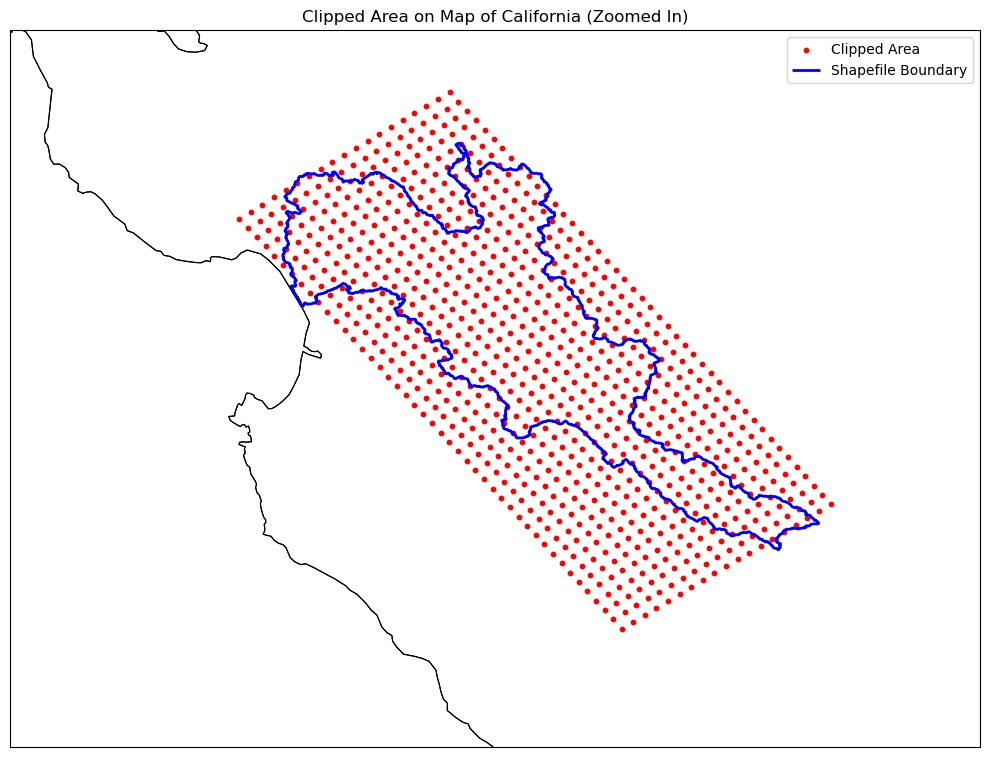

In [7]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

clip_shp_data = clip_shp.execute(data, {})
# plot the clipped data
import matplotlib.pyplot as plt

key = list(clip_shp_data.keys())[0]
lon = clip_shp_data[key].lon.values
lat = clip_shp_data[key].lat.values

# Only plot the clipped region on a map of California, zoomed in
# California bounding box (zoomed in)
ca_lon_zoom = [-122.5, -120.2]
ca_lat_zoom = [35.8, 37.5]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

print("adding map features...")
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

ax.set_title("Clipped Area on Map of California (Zoomed In)")
ax.set_xlim(ca_lon_zoom)
ax.set_ylim(ca_lat_zoom)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Plot the clipped grid points
ax.scatter(lon.flatten(), lat.flatten(), s=10, c='red', label='Clipped Area')

# Overlay the shapefile boundary
gdf = gpd.read_file(pajaro).to_crs(ccrs.PlateCarree().proj4_init)
gdf.boundary.plot(ax=ax, color='blue', linewidth=2, label='Shapefile Boundary')

ax.legend()
plt.tight_layout()
plt.show()


In [8]:
pajaro_lat_lon = ((37.4, 36.2), (-121.4, -121.2))

clip_lat_lon = Clip(pajaro_lat_lon)
clip_lat_lon_data = clip_lat_lon.execute(data, {})

Clipping pv_utility.WRF.ERA.MPI-ESM1-2-HR.historical.day.d03 with slice: {'y': slice(1193194.693395725, 1308068.988861803, None), 'x': slice(-4208075.905842967, -4116232.858013558, None)}
Lat data before clipping: 454911.73069853615, 1927911.7306985362
Lon data before clipping: -4335113.661860974, -3609113.6618609736
Clipping pv_utility.WRF.ERA.EC-Earth3.historical.day.d03 with slice: {'y': slice(inf, inf, None), 'x': slice(inf, inf, None)}
Lat data before clipping: 454911.73069853615, 1927911.7306985362
Lon data before clipping: -4335113.661860974, -3609113.6618609736
Clipping pv_utility.WRF.ERA.MIROC6.historical.day.d03 with slice: {'y': slice(inf, inf, None), 'x': slice(inf, inf, None)}
Lat data before clipping: 454911.73069853615, 1927911.7306985362
Lon data before clipping: -4335113.661860974, -3609113.6618609736
Clipping pv_utility.WRF.ERA.TaiESM1.historical.day.d03 with slice: {'y': slice(inf, inf, None), 'x': slice(inf, inf, None)}
Lat data before clipping: 454911.73069853615, 

adding map features...


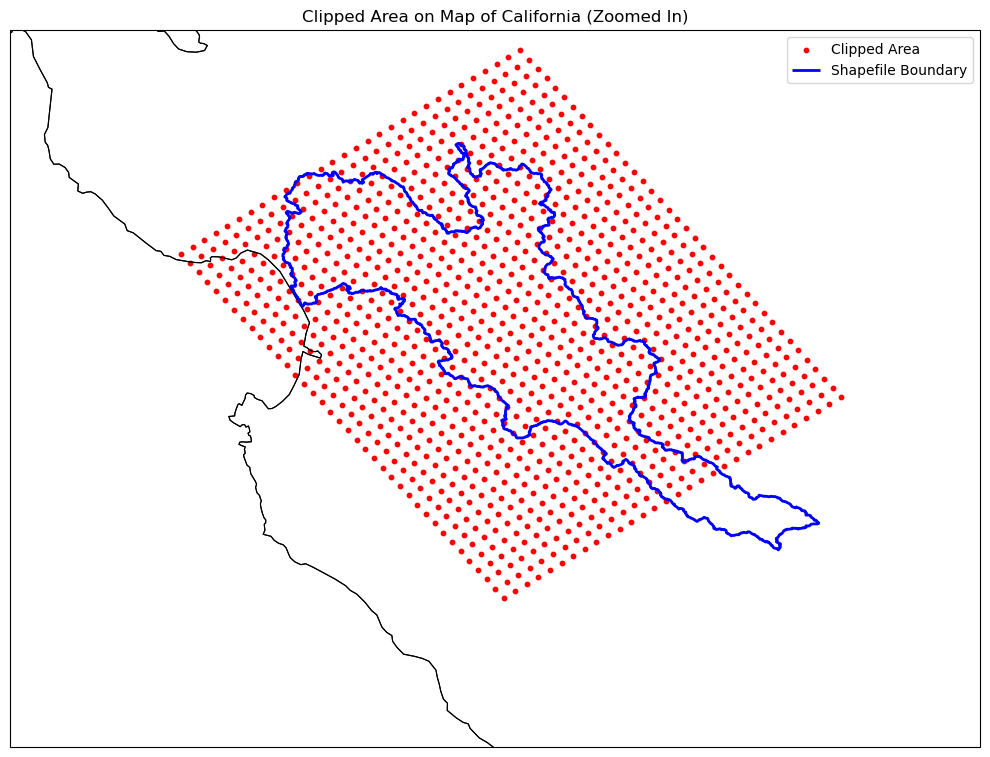

In [9]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# plot the clipped data
import matplotlib.pyplot as plt

key = list(clip_lat_lon_data.keys())[0]
lon = clip_lat_lon_data[key].lon.values
lat = clip_lat_lon_data[key].lat.values

# Only plot the clipped region on a map of California, zoomed in
# California bounding box (zoomed in)
ca_lon_zoom = [-122.5, -120.2]
ca_lat_zoom = [35.8, 37.5]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

print("adding map features...")
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

ax.set_title("Clipped Area on Map of California (Zoomed In)")
ax.set_xlim(ca_lon_zoom)
ax.set_ylim(ca_lat_zoom)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Plot the clipped grid points
ax.scatter(lon.flatten(), lat.flatten(), s=10, c='red', label='Clipped Area')

# Overlay the shapefile boundary
gdf = gpd.read_file(pajaro).to_crs(ccrs.PlateCarree().proj4_init)
gdf.boundary.plot(ax=ax, color='blue', linewidth=2, label='Shapefile Boundary')

ax.legend()
plt.tight_layout()
plt.show()